In [3]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

In [5]:
train_df = pd.read_csv("msr_paraphrase_train.csv")
train_df.head()

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
3,0,3344667,3344648,"Around 0335 GMT, Tab shares were up 19 cents, ...","Tab shares jumped 20 cents, or 4.6%, to set a ..."
4,1,1236820,1236712,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...


In [6]:
train_df.shape

(4076, 5)

In [7]:
test_df = pd.read_csv("msr_paraphrase_test.csv")
test_df.head()

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,1089874,1089925,"PCCW's chief operating officer, Mike Butcher, ...",Current Chief Operating Officer Mike Butcher a...
1,1,3019446,3019327,The world's two largest automakers said their ...,Domestic sales at both GM and No. 2 Ford Motor...
2,1,1945605,1945824,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...
3,0,1430402,1430329,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...
4,0,3354381,3354396,The company didn't detail the costs of the rep...,But company officials expect the costs of the ...


In [8]:
test_df.shape

(1725, 5)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Quality    4076 non-null   int64 
 1   #1 ID      4076 non-null   int64 
 2   #2 ID      4076 non-null   int64 
 3   #1 String  4076 non-null   object
 4   #2 String  4045 non-null   object
dtypes: int64(3), object(2)
memory usage: 159.3+ KB


In [10]:
# Checking for duplicate rows in the dataset
duplicates = train_df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [11]:
# Check for nulls
nulls = train_df.isnull()
print("Number of missing values :\n", nulls.sum())

Number of missing values :
 Quality       0
#1 ID         0
#2 ID         0
#1 String     0
#2 String    31
dtype: int64


In [12]:
# Drop the null values
train_df.dropna(inplace=True)
nulls = train_df.isnull()
print("Number of missing values :\n", nulls.sum())

Number of missing values :
 Quality      0
#1 ID        0
#2 ID        0
#1 String    0
#2 String    0
dtype: int64


In [13]:
# Distribution of Similar and non-similar strings
fig = px.pie(train_df, values='#1 ID', names='Quality', title='Class Distribution for Train Data')
fig.show()

In [14]:
# Cleaning function for the strings
wn = nltk.WordNetLemmatizer()

def clean_string(input_str):
    
    # Lowercase the input_string
    input_str = input_str.lower()
    
    # Remove URLs, links
    input_str = re.sub(r"http\S+", "", input_str)
    input_str = re.sub(r"www.\S+", "", input_str)
    input_str = re.sub(r"\S+@\S+", "", input_str)
    
    # Remove punctuations
    input_str_cleaned = "".join(char for char in input_str if char not in string.punctuation)

    # # Remove stopwords
    # stopword = nltk.corpus.stopwords.words('english')
    # input_str_stopwords = " ".join([word for word in re.split('\W+', input_str_punc) if word not in stopword])
    
    # # Lemmatization
    # input_str_cleaned = " ".join([wn.lemmatize(word,'n') for word in re.split('\W+', input_str_stopwords)])

    return input_str_cleaned

In [15]:
# Apply cleaning function on the #1 and #2 String columns in Train Data
train_df['sentence_1'] = train_df['#1 String'].apply(clean_string)
train_df['sentence_2'] = train_df['#2 String'].apply(clean_string)
train_df[['#1 String', 'sentence_1', '#2 String', 'sentence_2']].head()

,#1 String,sentence_1,#2 String,sentence_2
0,"Amrozi accused his brother, whom he called ""th...",amrozi accused his brother whom he called the ...,"Referring to him as only ""the witness"", Amrozi...",referring to him as only the witness amrozi ac...
1,Yucaipa owned Dominick's before selling the ch...,yucaipa owned dominicks before selling the cha...,Yucaipa bought Dominick's in 1995 for $693 mil...,yucaipa bought dominicks in 1995 for 693 milli...
2,They had published an advertisement on the Int...,they had published an advertisement on the int...,"On June 10, the ship's owners had published an...",on june 10 the ships owners had published an a...
3,"Around 0335 GMT, Tab shares were up 19 cents, ...",around 0335 gmt tab shares were up 19 cents or...,"Tab shares jumped 20 cents, or 4.6%, to set a ...",tab shares jumped 20 cents or 46 to set a reco...
4,"The stock rose $2.11, or about 11 percent, to ...",the stock rose 211 or about 11 percent to clos...,PG&E Corp. shares jumped $1.63 or 8 percent to...,pge corp shares jumped 163 or 8 percent to 210...


In [16]:
# Prepare Test data similar to Train data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Quality    1725 non-null   int64 
 1   #1 ID      1725 non-null   int64 
 2   #2 ID      1725 non-null   int64 
 3   #1 String  1725 non-null   object
 4   #2 String  1713 non-null   object
dtypes: int64(3), object(2)
memory usage: 67.5+ KB


In [17]:
# Checking for duplicate rows in the dataset
duplicates = test_df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

# Check for nulls
nulls = test_df.isnull()
print("Number of missing values :\n", nulls.sum())

Number of duplicate rows: 0
Number of missing values :
 Quality       0
#1 ID         0
#2 ID         0
#1 String     0
#2 String    12
dtype: int64


In [18]:
# Drop the null values
test_df.dropna(inplace=True)
nulls = test_df.isnull()
print("Number of missing values :\n", nulls.sum())

Number of missing values :
 Quality      0
#1 ID        0
#2 ID        0
#1 String    0
#2 String    0
dtype: int64


In [19]:
# Distribution of Similar and non-similar strings
fig = px.pie(test_df, values='#1 ID', names='Quality', title='Class Distribution for Test Data')
fig.show()

In [20]:
# Apply cleaning function on the #1 and #2 String columns in Test Data
test_df['sentence_1'] = test_df['#1 String'].apply(clean_string)
test_df['sentence_2'] = test_df['#2 String'].apply(clean_string)
test_df[['#1 String', 'sentence_1', '#2 String', 'sentence_2']].head()

,#1 String,sentence_1,#2 String,sentence_2
0,"PCCW's chief operating officer, Mike Butcher, ...",pccws chief operating officer mike butcher and...,Current Chief Operating Officer Mike Butcher a...,current chief operating officer mike butcher a...
1,The world's two largest automakers said their ...,the worlds two largest automakers said their u...,Domestic sales at both GM and No. 2 Ford Motor...,domestic sales at both gm and no 2 ford motor ...
2,According to the federal Centers for Disease C...,according to the federal centers for disease c...,The Centers for Disease Control and Prevention...,the centers for disease control and prevention...
3,A tropical storm rapidly developed in the Gulf...,a tropical storm rapidly developed in the gulf...,A tropical storm rapidly developed in the Gulf...,a tropical storm rapidly developed in the gulf...
4,The company didn't detail the costs of the rep...,the company didnt detail the costs of the repl...,But company officials expect the costs of the ...,but company officials expect the costs of the ...


In [21]:
import sys

print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

__Python VERSION: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
__pyTorch VERSION: 1.13.1+cu116
__CUDA VERSION
__CUDNN VERSION: 8302
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
cuda:0


In [22]:
# Split the dataset into training and validation sets
# train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
train_data = train_df[['Quality', 'sentence_1', 'sentence_2']]
val_data = test_df[['Quality', 'sentence_1', 'sentence_2']]

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and prepare the input data
def tokenize_data(data, max_length=128):
    input_ids = []
    attention_masks = []

    for index, row in data.iterrows():
        encoded = tokenizer.encode_plus(row['sentence_1'], row['sentence_2'], max_length=max_length,
                                        pad_to_max_length=True, truncation=True, return_attention_mask=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_data(train_data)
val_input_ids, val_attention_masks = tokenize_data(val_data)

# Create PyTorch datasets and data loaders
train_labels = torch.tensor(train_data['Quality'].values).to(device)
val_labels = torch.tensor(val_data['Quality'].values).to(device)

train_inputs = torch.tensor(train_input_ids).to(device)
val_inputs = torch.tensor(val_input_ids).to(device)

train_masks = torch.tensor(train_attention_masks).to(device)
val_masks = torch.tensor(val_attention_masks).to(device)

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

batch_size = 16

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [23]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create a learning rate scheduler
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [24]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_train_loss = 0

    for batch in dataloader:
        input_ids, attention_masks, labels = batch
        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    return total_train_loss / len(dataloader)

# Validation function
def validate_epoch(model, dataloader, device):
    model.eval()
    total_val_loss = 0

    for batch in dataloader:
        input_ids, attention_masks, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    return total_val_loss / len(dataloader)

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}")

    val_loss = validate_epoch(model, val_dataloader, device)
    print(f"Validation Loss: {val_loss:.4f}")


Epoch 1/3
Training Loss: 0.5165
Validation Loss: 0.4265
Epoch 2/3
Training Loss: 0.3405
Validation Loss: 0.4079
Epoch 3/3
Training Loss: 0.2177
Validation Loss: 0.4778


Accuracy: 0.8260
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       574
           1       0.86      0.88      0.87      1139

    accuracy                           0.83      1713
   macro avg       0.81      0.80      0.80      1713
weighted avg       0.82      0.83      0.82      1713



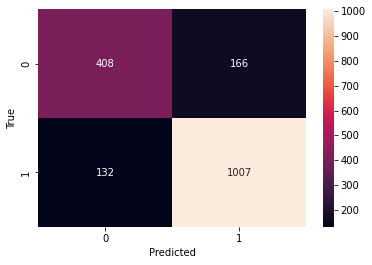

In [25]:
# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        input_ids, attention_masks, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_labels.extend(labels.flatten())

    return predictions, true_labels

# Evaluate the model
predictions, true_labels = evaluate_model(model, val_dataloader, device)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print(classification_report(true_labels, predictions))

# Plot the confusion matrix
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()